<a href="https://colab.research.google.com/github/JoDeMiro/SACI22/blob/main/SACI22_019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Scikit -> Keras

- **Ez a doksi a SACI22K_010.ipynb** notebookból let származtatva.

### Egy bemeneti változó helyett több bemeneti változó.

<p>&#127947; No skin tone</p>


### Amiben alapvető változás van minden korábbihoz képest:

- képes több bemeneti változón is elvégezni a lookback window átalakítást

- és ezt meg is kapja a neurális háló bemenetkként mátrix (2D ndarray) fomrában.

### SACI2022K_010 hez képest

- megpróbálom megvalósítani, hogy teszt adatokon is képes legyen tesztelni a stratégiát

### ToDo:

- [ ] Tesztelni, hogy hibátlanül müködik-e egy bemeneti változó esetében is

- [ ] Tesztelni, hogy be tudom-e rakni a dummy változót úgy hogy ne keljen átalakítani semmit

- [ ] Átnézni a dataprocessing flow-t

In [2]:
# ------------------------------------------------------------------------------

!mkdir input
!wget https://raw.githubusercontent.com/JoDeMiro/SACI2022/main/Input/eurusd_minute_1000000.csv.gz     # <-- másik project
!mv eurusd_minute_1000000.csv.gz ./input/
!cd input
!gzip -f -d ./input/eurusd_minute_1000000.csv.gz
!rm ./input/eurusd_minute.csv
!mv ./input/eurusd_minute_1000000.csv ./input/eurusd_minute.csv

# ------------------------------------------------------------------------------

mkdir: cannot create directory ‘input’: File exists
--2023-02-15 15:29:20--  https://raw.githubusercontent.com/JoDeMiro/SACI2022/main/Input/eurusd_minute_1000000.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12887930 (12M) [application/octet-stream]
Saving to: ‘eurusd_minute_1000000.csv.gz’

eurusd_minute_10000 100%[===================>]  12.29M  --.-KB/s    in 0.08s   

2023-02-15 15:29:21 (162 MB/s) - ‘eurusd_minute_1000000.csv.gz’ saved [12887930/12887930]



In [3]:
import os
import sys
import glob
import keras
import pprint
import sklearn
import ipywidgets
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.layers import Dense, Activation

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Checkbox
from IPython.display import display

from matplotlib.ticker import StrMethodFormatter

import time
import talib
import random
import joblib
from sys import maxsize

print('Python version:{}'.format(sys.version))
print('Numpy version:{}'.format(np.__version__))
print('Pandas version:{}'.format(pd.__version__))
print('Keras version:{}'.format(keras.__version__))
print('Tensorflow version:{}'.format(tf.__version__))
print('Sci-Kit Learn version:{}'.format(sklearn.__version__)) 

Python version:3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
Numpy version:1.23.5
Pandas version:1.3.5
Keras version:2.10.0
Tensorflow version:2.10.0
Sci-Kit Learn version:1.0.2


## Hogyan néz ki scikitben amikor több mint egy bemeneti változó van.

Egy gyors alapvizsgálat, hogyan néz ki ez scikit learniben.

A jó hír az, hogy a bemeneti változón nem nagyon kell változtatnom.

Az egyetlen ami kérdéses, az hogy a Randomerben hogyan oldottam meg a súlymátrixok variálását.

**ToDo:?:÷**
- [ ] Feljegyezni a komolyabb változtatásokat

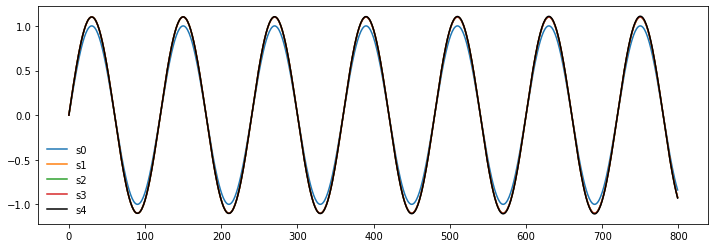

In [4]:
def sin(length, p, m, l, t, e):
    'Dummy generator'
    
    ll, l = l

    x = np.arange(0, length, 1)
    s0 = np.sin(x/180*np.pi*p)                        # p = phase
    s1 = m*np.sin(x/180*np.pi*p)                      # m = magnitúdó
    s2 = m*np.sin(x/180*np.pi*(1+(l*(x/ll)))*p)       # l = longitude modulation
    s3 = m*np.sin(x/180*np.pi*(1+(l*(x/ll)))*p)+x*t   # t = linear trend
    s4 = (m+(m*e*x))*np.sin(x/180*np.pi*(1+(l*(x/ll)))*p)+x*t

    plt.figure(figsize=(12, 4))
    plt.plot(s0, label='s0')
    plt.plot(s1, label='s1')
    plt.plot(s2, label='s2')
    plt.plot(s3, label='s3')
    plt.plot(s4, label='s4', color='black')    

    plt.legend(frameon=False)
    plt.show()
    
    return s4
    

_ = sin(length=800, p=3.0, m=1.1, l=(179.0, 0.00000003), t=0.00000003, e=0.00001)


In [5]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# végig néztem, data_readr-ben csak az x_train, y_train, y_train_originalt használom

class DataReader():
  """
  DataReader is responsible for holding, store the data and the basic
  data manipulation.
  """

  def __init__(self, nRowsRead):
    """
    :param nRowsRead: Number of rows read from the csv file via pandas.
    """
    self.nRowsRead = nRowsRead
    self.dataset = None
    self.dataset_diff = None
    self.dataset_stacked = None
    self.window = None

# ------------------------------------------------------------------------------

  def load_with_pandas(self, path = './input/eurusd_minute.csv'):
    """
    Load ./input/eurusd_minute.csv int pandas dataframe.
    """
    self.df = pd.read_csv(path, delimiter=',', nrows = self.nRowsRead)             # <-- read csv to pandas dataframe
    self.df.dataframeName = 'eurusd_minute.csv'

    self.n_row, self.n_col = self.df.shape
    print(f'There are {self.n_row} rows and {self.n_col} columns')                  # <-- print nRow, nCol
    print(self.df.head(5))                                                         # <-- print head
    self.println()

    return self.df

# ------------------------------------------------------------------------------

  def cut(self, start: int, end: int):
    """
    Cut or Crop the dataframe.
    """
    self.df = self.df.iloc[start:end, :]    
    print(self.df.shape)
        
# ------------------------------------------------------------------------------

  def create_dummy(self, length, p, m, l=(179.0, 0.0), t=0.0, e=0.0):
    """
    Create dummy data
    """
    x = np.arange(0, length, 1)
    s = np.sin(x/180*np.pi*p)
    s = sin(length, p, m, l, t, e)


    xs = np.dstack((x,s))
    xs = np.squeeze(xs, axis=0)

    df = pd.DataFrame(xs, columns = ['Date','BC'])
    
    self.df = df

# ------------------------------------------------------------------------------
  def info(self):
    """
    Print out the basic information about the loaded dataframe.
    """
    print('Info:')
    print(self.df.BC.values.ctypes)
    print(self.df.BC.values.dtype)
    print(self.df.BC.values.itemsize)
    print(self.df.BC.values.nbytes)

    print('BC.nbytes =', self.df.BC.values.nbytes)
    print('BC.nbytes =', self.df.BC.values.nbytes / 1000, 'Kbyte')
    self.println()

# ------------------------------------------------------------------------------

  def set_target(self):
    """
    Perform the necessery data transormation.
    For example: Keep only the BC and the Date columns.
    """

    # For BC column only
    self.df.set_index(['Date'], inplace=True)              # <-- set index column
    self.target = self.df.filter(['BC'])                   # <-- select only the BC column
    self.array = self.target.values                        # --> from pandas.series -> numpy.ndarray


# ------------------------------------------------------------------------------

  def create_diff(self, emphasize):
    """
    Create diff n=1.
    """
    original = self.array
    diff = np.diff(original[:,0], n=1, prepend=original[0])       # Az array első oszlpán 
    diff = diff * emphasize                                 # mivel ez pici ért és nem akarom normálni
    diff = diff.reshape(-1, 1)
    plt.plot(diff)
    
    print(original.shape)
    print(diff.shape)
    
    self.println()

    hstack = np.hstack((original, diff))
    hstack.shape                              # (10000, 2)
    
    self.input = hstack

# ------------------------------------------------------------------------------

  def create_indicators(self):
    '''
    Bármit csinálok, állítok itt elő az legyen hozzácsapva a self.inputhoz
    és az akármit adok hozzá az mindíg a self.input hosszával legyen azonos
    :Ha hiányzó adattal kell kipótolnom, mint például a mozgóátlag,
    akkor a hiányzó érték legyen np.nan
    :A self.array az a változó amin valamit mókolunk és azt adjuk hozzá
    a self.inputhoz
    :Bár a self.inputból is lehet levállogatni ha az élet úgy hozza, de
    azzal zavar keletkezhet ha nem a megfelelő sorrandben hajtom végre
    az egyes parancsokat -->> ezért ezt soha ne tegyük.
    :Akkor már inkább paraméterként adjunk át neki valamit --> egy másik fgben
    '''
    original = self.array
    
    original = original.flatten()    # az original és a self.array is mindíg 1D de (n, 1)
    
    
    # ** check **
    print(original.shape)
    print(self.input.shape)
    
    print('indcator section')
    
    # ffff
    
    _indicator = talib.SMA(real = original, timeperiod = 30)
    _indicator[:30] = _indicator[30]
    _indicator = _indicator.reshape(-1, 1)

    assert _indicator.shape[0] == self.input.shape[0]

    self.input = np.hstack((self.input, _indicator))
    
    self.input = self.input
    
    self.println()
    pass

# ------------------------------------------------------------------------------

  def show_array_info(self):
    """
    Print out the basic information about the transformed dataframe.
    """
    self.println()
    print(type(self.array))
    print(self.array.shape)
    self.println()

# ------------------------------------------------------------------------------

  def normalize_values(self):
    """
    Normalize the whole input array.
    It transforms the whole dataframe between {-1,+1}.
    """
    
    # Bug:
    # The windowed data should be normalized respectivley, not the whole dataframe.

    self.scaler      = MinMaxScaler(feature_range=(-1, 1))                   # <-- (0, 1) vagy (-1, 1)
    self.input       = self.scaler.fit_transform(self.input)
    
# ------------------------------------------------------------------------------

  def set_window(self, value: int):
    """
    Set the lookback window size.
    :param value: The lookback period.
    """
    if type(value) is int:
      self.window = value
      print('Set window =', self.window)
    else:
      print('Error: Not proper type of parameter')
    self.println()

# ------------------------------------------------------------------------------

  def create_train_set(self):
    """
    Creates the train and the test dataset.
    """

    self.x_train = []
    self.y_train = []    # --> soha nem fogjuk használni emiatt csak az nn weigth inithez kell
    
    self.y_train = self.array[self.window:,] # le kell vágni az y_train-t hogy az x_trainel azonos h. legyen


    for i in range(self.window, len(self.input)):
        # self.x_train.append(self.input[i-self.window:i, 0])               # egy konkrét oszlop -> nem jó
        # self.x_train.append(self.input[i-self.window:i, 0:2])             # új   [, 0:2]  az első két oszlop
        self.x_train.append(self.input[i-self.window:i, :])               # új [, :] az összes oszlop
        # self.y_train.append(self.array[i, 0])                           # felesleges a self.y_train nem használjuk

    print('The train dataset {}, and the labels {}'.format(len(self.x_train), len(self.y_train)))

    self.x_train, self.y_train = np.array(self.x_train), np.array(self.y_train)   # <-- Convert list to Numpy Array

    print(self.x_train.shape, self.y_train.shape)
    
    print('x_train.nbytes = ', self.x_train.nbytes/1000, 'Kbyte')
    print('x_train.nbytes = ', self.x_train.nbytes/1000/1000, 'Mbyte')


    # Mivel az MLPRegressioin nem képes csak 2D tömöbket fogadni bemenetnek ezért kell ez az átalakítás
    
    _ = []
    for i in range(self.x_train.shape[-1]):
        _.append(self.x_train[:, :, i])
    _ = tuple(_)
    self.x_train = np.hstack(_)

    self.x_train

    # <-- így néz ki a helyes összefűzési mód -> így már lehet az MLPRegression bemente
    
    self.println()


  def println(self):
    print('------------------------------------------------------------------------------')



## Program

mi legyen a flow?

    read_csv -> cut -> prepare(normalize) -> create diff -> create_indicator -> set_window -> create_train_set
    create_test_set
    
    self.target = BC pandas series-ben
    self.array = BC numpy array formában
    self.input = a bemeneti változók 2D numpy array tömbben (row, col) (close, diff, inicators, etc)
    self.x_train = a windowval sokszorosított numpy array
    self.y_train = self.array
    
    self.df = az eredeti beolvasott csv pandas dataframe formában

There are 200 rows and 12 columns
         Date   Time      BO      BH      BL      BC  BCh      AO      AH  \
0  2005-01-02  18:29  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
1  2005-01-02  18:38  1.3555  1.3555  1.3555  1.3555  0.0  1.3565  1.3565   
2  2005-01-02  18:51  1.3562  1.3562  1.3562  1.3562  0.0  1.3572  1.3572   
3  2005-01-02  18:52  1.3560  1.3560  1.3560  1.3560  0.0  1.3570  1.3570   
4  2005-01-02  18:55  1.3563  1.3563  1.3563  1.3563  0.0  1.3573  1.3573   

       AL      AC  ACh  
0  1.3565  1.3565  0.0  
1  1.3565  1.3565  0.0  
2  1.3572  1.3572  0.0  
3  1.3570  1.3570  0.0  
4  1.3573  1.3573  0.0  
------------------------------------------------------------------------------
(100, 12)
Info:
float64
8
800
BC.nbytes = 800
BC.nbytes = 0.8 Kbyte
------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column  Non-Null C

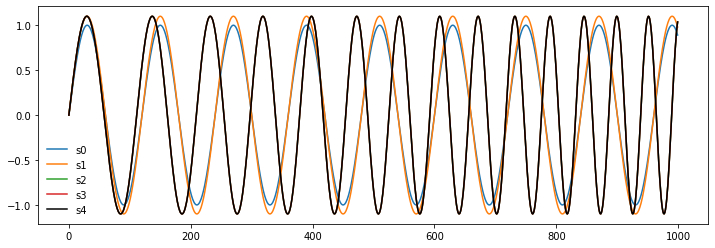

------------------------------------------------------------------------------
<class 'numpy.ndarray'>
(1000, 1)
------------------------------------------------------------------------------
(1000, 1)
(1000, 1)
------------------------------------------------------------------------------
(1000,)
(1000, 2)
indcator section
------------------------------------------------------------------------------
Set window = 10
------------------------------------------------------------------------------
The train dataset 990, and the labels 990
(990, 10, 3) (990, 1)
x_train.nbytes =  237.6 Kbyte
x_train.nbytes =  0.2376 Mbyte
------------------------------------------------------------------------------


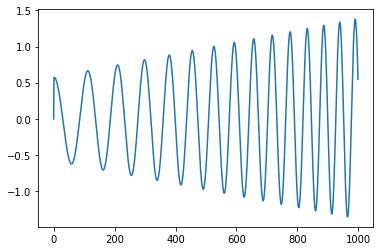

In [6]:
# ------------------------------------------------------------------------------

data_reader = DataReader(nRowsRead=200)                                       # <-- instantiate DataReader (set number of rows for data)

df2 = data_reader.load_with_pandas(path = './input/eurusd_minute.csv')          # <-- read a particular files from disk (return with df, but also set self)

data_reader.cut(0, 100)                                                       # <-- cut from to (start, to)

data_reader.info()                                                              # <-- my own info() function

data_reader.df.info()                                                           # <-- call pandas built-in info() function

data_reader.create_dummy(1000, 3.0, 1.1, (1700, 1.2))

data_reader.set_target()                                                        # <-- prepare is setter convert pandas to numpy and set target variable

data_reader.show_array_info()

data_reader.create_diff(10)        # innentől self.input

data_reader.create_indicators()

data_reader.normalize_values()                                                  # <-- transform data between range (-1,1)

data_reader.set_window(10)                                                      # <-- set window size

data_reader.create_train_set()                                                  # <-- prepare egyik legfontossab metódusa (sok transzformációval)



In [7]:
print(data_reader.window)

print(data_reader.x_train.shape)
print(data_reader.y_train.shape)

print(data_reader.input.shape)
print(data_reader.array.shape)

print(data_reader.df.shape)
print(data_reader.df.head(3))


10
(990, 30)
(990, 1)
(1000, 3)
(1000, 1)
(1000, 1)
            BC
Date          
0.0   0.000000
1.0   0.057610
2.0   0.115143


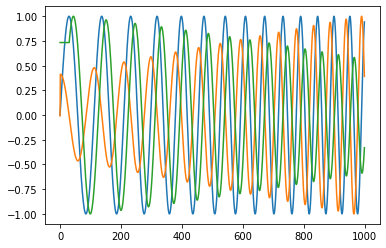

In [8]:
plt.plot(data_reader.input[:,0])
plt.plot(data_reader.input[:,1])
plt.plot(data_reader.input[:,2])

In [9]:

# ----------------------------------------------------------------------------------

# Segéd függvények a plottoláshoz

# ----------------------------------------------------------------------------------

def plot_trade_adv(trader, trader_signal=None, save=False, j=1, g='', _from=0, _back=0, window=0, step=False):
    '''
    Csak a plottolásért felelős, minden adatot paraméterként kap.
    Semmit nem lát a függvényen kívűl.
    '''
    
    size = trader.data_reader.y_train.shape[0]
    start = _from
    end   = size - _back

    fig, ax1 = plt.subplots(figsize=(20, 5))

    ax2 = ax1.twinx()

    # Plot 1
    ax1.plot(trader.data_reader.y_train[start:end,])
    

    # Plot 2
    __eq = trader.calculate_equity()

    if step == True:
        plt.plot(__eq[start:end,], color='C1', drawstyle='steps-post', label='Cum Equity steps-post')
    else:
        plt.plot(__eq[start:end,], color='C1', label='Cum Equity')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close price USD ($)', color='C0')
    ax2.set_ylabel('Cum. Equity', color='C1')

    plt.title('Close price history with Equity at gen = ' + str(g))
    plt.gca().yaxis.set_major_formatter(
        StrMethodFormatter('{x:,.4f}'))  # 4 decimal places

    chart_y_max = trader.data_reader.y_train[start:end].max()
    chart_y_min = trader.data_reader.y_train[start:end].min()
    
    
    # Buy price
    buy_price_array = np.zeros((size))
    buy_price_array[:] = np.nan
    for i in range(len(trader.result['buy_index'])):
        buy_idx  = int(trader.result['buy_index'][i])
        sell_idx = int(trader.result['sell_index'][i])

        # vertical lines
        if buy_idx >= start and buy_idx <= end:
            ax1.vlines(trader.result['buy_index'][i] - start,
                       chart_y_min,
                       chart_y_max,
                       lw=0.5,
                       ls='dashed',
                       color='black')
        if sell_idx >= start and sell_idx <= end:
            ax1.vlines(trader.result['sell_index'][i] - start,
                       chart_y_min,
                       chart_y_max,
                       lw=0.5,
                       color='black')
        
        # buy_price_array
        buy_price_array[buy_idx:sell_idx+0] = trader.result['buy_price'][i]

    # buy_price_array
    ax1.plot(buy_price_array[start:end], color='black', lw=2, drawstyle='steps-post')


    # Signal
    if isinstance(trader_signal, (np.ndarray, np.generic) ):
        ax3 = ax1.twinx()
        ax3.plot(trader_signal[start:end], color='C2')
        ax3.hlines(trader.threshold, xmin=0, xmax=end-start, lw=0.5, linestyle='dashed', color='black')
        ax3.hlines(trader.th_up, xmin=0, xmax=end-start, lw=0.5, linestyle='dashed', color='C4')
        ax3.hlines(trader.th_dn, xmin=0, xmax=end-start, lw=0.5, linestyle='dashed', color='C5')
        ax3.set_yticks([-1.0, 0, 1.0])
        
    if save == False:
        plt.show()
    
    if save == True:
        plt.savefig('price_{0:04}'.format(j) + '.png')
        plt.close('all')


# ----------------------------------------------------------------------------------


def create_animated_mp4(filter='price*.png', prefix='ani_', framerate=10, quite=True):
    postfix = ' 2> /dev/null' if quite else ''
    output = prefix + filter[0:filter.find('*')] + '.mp4'
    os.system('rm ' + output)
    if (len(glob.glob(filter)) > 0):
        os.system('ffmpeg -r ' + str(framerate) + ' -pattern_type glob -i "' +
                  filter + '" -vcodec libx264 -crf 25 -pix_fmt yuv420p ' +
                  output + postfix)

        print('ok')
    else:
        print('skipped')
        pass

## NN osztály

Ez egy érdekes állat lesz, mert a **Driver** és a **Worker** is használni fogja.



In [10]:
# ------------------------------------------------------------------------------    # <-- NN Class

# Neural Network Class

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter(
    "ignore",
    category=ConvergenceWarning)      # <-- kell a Convergencia Warning miatt
simplefilter("ignore")                # <-- a batch_size > n miatt kell ide

import numpy as np
from sklearn.neural_network import MLPRegressor
from copy import deepcopy

# ------------------------------------------------------------------------------


class NN():

    def __init__(self, x_train, y_train):
        self.mlp = None
        # self.x_train = np.squeeze(x_train, axis=-1)
        self.x_train = x_train
        self.y_train = y_train
        self.prediction = None

# ------------------------------------------------------------------------------

    def init_nn(self, _first=15, _second=5, activation='tanh'):
        'Init Scikit Learn MLPRegressor'  # <-- hogy létre jöjjenek a súlyok inicializálni kell

        np.random.seed(1)

        mlp = MLPRegressor(
            hidden_layer_sizes=(_first, _second),
            activation=activation,                     # -------> ha (MinMax(-1,1) vagy StandardScaler())
            solver='sgd',
            batch_size=9900000,         # <<-- v.017 bug fixed
            max_iter=1,                 # <-- sajnos legalább 1 kell hogy legyen
            shuffle=False,
            random_state=1,
            learning_rate_init=
            0.0000000001,               # >- lehetőleg ne tanuljon semmit GD alapján
            validation_fraction=0.0,
            n_iter_no_change=99999999)  # ----->   Behoztam ide az első illesztést is, hogy meglegyenek neki a súlyok

        np.random.seed(1)

        y_random = np.zeros(
            (self.y_train.shape[0])
        ) * 0.0123                      # --> tök random adaton tanítom, hogy még véletlenül se tanuljon

        mlp.fit(
            self.x_train, y_random
        )                               # --> nem akarjuk mi semmire megtanítani csak kell az inithez

        self.mlp = mlp

        return mlp

# ------------------------------------------------------------------------------

    def create_prediction(self):
        'Saját adati alapján csinája meg a predcitiont'

        self.prediction = self.mlp.predict(self.x_train)

        return self.prediction

# ------------------------------------------------------------------------------

    def mlp_reinitalizer(self, fac: float) -> MLPRegressor:

        mlp = deepcopy(self.mlp)

        for i, c in enumerate(mlp.coefs_):
            _ = np.random.rand(c.shape[0], c.shape[1]) * fac                   # uniform
            _ = np.random.normal(0, 1, size=(c.shape[0], c.shape[1])) * fac    # normal
            mlp.coefs_[i] = _

        for i, c in enumerate(mlp.intercepts_):
            if len(c.shape) == 2:
                _ = np.random.rand(c.shape[0], c.shape[1]) * fac
                _ = np.random.normal(0, 1, size=(c.shape[0], c.shape[1])) * fac
            if len(c.shape) == 1:
                _ = np.random.rand(c.shape[0]) * fac
                _ = np.random.normal(0, 1, size=(c.shape[0])) * fac

            mlp.intercepts_[i] = _
        
        self.mlp = deepcopy(mlp)        # felül csapom az initializált mlp-ta

        return mlp

# ------------------------------------------------------------------------------

    def knn_to_snn(self, kn):
        'keras model to scikit model'

        'természetesen csak regressziós és fc modellekre'

        _weights = []
        _biases  = []

        weights = kn.mlp.get_weights()
        for i in range(len(weights)):
            if i % 2 == 0:
                _w = weights[i].astype('float64')
                _weights.append(_w)
            if i % 2 == 1:
                _b = weights[i].astype('float64')
                _biases.append(_b)
        
        self.mlp.coefs_ = _weights
        self.mlp.intercepts_ = _biases

        return _weights, _biases

# ------------------------------------------------------------------------------

In [11]:
# ------------------------------------------------------------------------------    # <-- NN Class

# Neural Network Keras Class

from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# ------------------------------------------------------------------------------


class KerasMLP():

    def __init__(self, x_train, y_train):
        self.mlp = None
        self.x_train = x_train
        self.y_train = y_train
        self.prediction = None
        tf.random.set_seed(1)

# ------------------------------------------------------------------------------

    def init_nn(self, _first=15, _second=5, activation='tanh'):
        'Init Keras MLP'  # <-- hogy létre jöjjenek a súlyok inicializálni kell

        np.random.seed(1)

        _input_shape = self.x_train.shape[1]  # <----------------------ezzel lesznek gondok, ha majd az indiket is hozzáadom

        mlp = Sequential()
        mlp.add(Dense(_first, input_shape=(_input_shape, ), activation=activation))
        mlp.add(Dense(_second, activation=activation))
        mlp.add(Dense(1))

        # ----->   Behoztam ide az első illesztést is, hogy meglegyenek neki a súlyok

        np.random.seed(1)

        y_random = np.zeros(
            (self.y_train.shape[0])
        ) * 0.0123  # --> tök random adaton tanítom, hogy még véletlenül se tanuljon

        mlp.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.0000001),
            loss='mean_absolute_error')

        history = mlp.fit(
            self.x_train,
            y_random,  # --> y_random és nem self.y_train, hogy véletlen adatokra illeszen
            epochs=1,
            shuffle=False,
            verbose=0,
            validation_split=0)

        self.mlp = mlp

        return mlp


# ------------------------------------------------------------------------------

    def create_prediction(self, batch_size):
        'Saját adatai alapján csinája meg a predcitiont'

        self.prediction = self.mlp.predict(self.x_train, batch_size=batch_size).flatten()
        
        return self.prediction

# ------------------------------------------------------------------------------


## Program

In [12]:
# ------------------------------------------------------------------------------

# Scikit
nn = NN(x_train = data_reader.x_train, y_train = data_reader.y_train)

nn.init_nn(_first = 15, _second = 5, activation='tanh')

# nn.mlp.coefs_                                                                     # <-- ha debuggolni kell

# ------------------------------------------------------------------------------

# Keras
kn = KerasMLP(x_train = data_reader.x_train, y_train = data_reader.y_train)

kn.init_nn(_first = 15, _second = 5, activation='tanh')

# kn.mlp.get_weights()                                                              # <-- ha debuggolni kell

# ------------------------------------------------------------------------------

2023-02-15 16:58:58.753445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-15 16:58:58.753514: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-15 16:58:58.753538: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter): /proc/driver/nvidia/version does not exist
2023-02-15 16:58:58.754252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# ------------------------------------------------------------------------------

# Create Prediction Scikit

# Tulikép 3 féle módon csinálom meg ugyan azt a becslést

# Azt azért jó lenne belátni, hogy ebből csak egyik félét kéne használni

mlp = nn.mlp

test_pred = mlp.predict(data_reader.x_train[:,:])                                 # teszt pred --> semmire nem fogjuk használni

print(test_pred[0:5])

test_pred = nn.mlp.predict(data_reader.x_train[:,:])                              # init után direktben is el lehet érni az mlp.predict() függvényt

print(test_pred[0:5])

test_pred = nn.create_prediction()                                                  # csináltam neki egy saját fügvényt ami elvégzi az egész predictiont

print(test_pred[0:5])


[-1.61527643 -1.7850377  -1.80527541 -1.81911323 -1.82741398]
[-1.61527643 -1.7850377  -1.80527541 -1.81911323 -1.82741398]
[-1.61527643 -1.7850377  -1.80527541 -1.81911323 -1.82741398]


## Trader class


    A fent leírt megoldás jónak tűnik ezért ezt fogom beépíteni a Trader osztály calculator_np osztályba



In [14]:
# ------------------------------------------------------------------------------    # <-- Trader Class

# Trader Calculator Class

import numpy as np
import time

class Trader():
    '''
    Trader Class is responsible for ..
    '''

    def __init__(self, threshold, data_reader, trade_cost=0.0001, th=0.0, debug=False):
        '''
        Initialize the class
        :param threshold: Bellow this value the trader sell the security
          Above this value the trader buy the security.
        '''
        self.threshold = threshold
        self.th_up = 0 + th                       # New
        self.th_dn = 0 - th                       # New
        
        self.data_reader = data_reader
        self.window = data_reader.window
        self.debug = debug
        
        self.trade_cost = trade_cost               # New
        
        self.t1 = []
        self.t2 = []
        self.ex = dict()

        self.signal = None
        self.result = dict()
        
        self.hossz = data_reader.y_train.shape[0]
        self.xx = np.arange(0, self.hossz, 1)
        self.buy_idx = np.empty((self.hossz))
        self.sell_idx = np.empty((self.hossz))
        
        print('__init__ Trader')

    def calculator_ff(self, pred: np.ndarray) -> dict:
        '''
        Calculete each trade on the data. It works as a Backtest Engine.
        :param pred: ndarray Predicted value of the Agent. Based on this the function
          calculates the trades and the Equity.
        '''
        begin = time.time()
        
        # -------------------------------
        
        buy = pred > self.th_up
        sell = pred < self.th_dn
        
        # ??? nem kell
        # buy[0] = True

        sunique, scounts = np.unique(sell, return_counts=True)
        sell_stat = dict(zip(sunique, scounts))

        bunique, bcounts = np.unique(buy, return_counts=True)
        buy_stat = dict(zip(bunique, bcounts))

        lenght = pred.size

        is_in_trade = False
        is_in_buy = False
        buy_count = 0
        sell_count = 0
        buy_price  = []
        sell_price = []
        buy_index  = []
        sell_index = []
        for i in range(lenght):
            if buy[i] == True and is_in_trade == False:
                buy_count += 1
                buy_price.append(self.data_reader.y_train[i]  )
                buy_index.append(i)
                is_in_trade = True

            if sell[i] == True and is_in_trade == True:
                sell_count += 1
                sell_price.append(self.data_reader.y_train[i])
                sell_index.append(i)
                is_in_trade = False

            if i == lenght - 1 and is_in_trade == True:  # <-- le kell zárni az utolsónál a vételt ha nyitva van
                sell_count += 1
                sell_price.append(self.data_reader.y_train[i])
                sell_index.append(i)
                is_in_trade = False
                
        
        elapsed_time = time.time() - begin
        self.t1.append(elapsed_time)
        
        # sell_idx és buy_idx alapján megállapítom a trade hosszát
        trade_length = np.array(sell_index) - np.array(buy_index)
        # print('trade_length: ', trade_length)
        
        # gains = np.array(sell_price) - np.array(buy_price)                 # Régi
        gains = np.array(sell_price) - np.array(buy_price) - self.trade_cost # New
        # print(gains)
        
        gain = gains.sum()
        # print(gain)

        
        self.elapsed_time_ff = time.time() - begin

        if (self.debug == True):
            print('Summary :')
            print('buy_stat = ', buy_stat)
            print('sell_stat = ', sell_stat)
            print('buy_count = ', buy_count)
            print('sell_count = ', sell_count)
            print('len(buy_price) = ', len(buy_price))
            print('len(sell_price) = ', len(sell_price))
            print('buy_price  = ', buy_price)
            print('sell_price = ', sell_price)
            print('buy_index  = ', buy_index)
            print('sell_index = ', sell_index)
            # print('gains      = ', gains)
            print('gain       = ', gain)

        self.result = {
            'buy_price': buy_price,
            'sell_price': sell_price,
            'buy_index': buy_index,
            'sell_index': sell_index,
            'trade_length': trade_length
        }

        result = {
            'buy_stat': buy_stat.get(True),
            'sell_stat': sell_stat.get(True),
            'buy_count': buy_count,
            'sell_count': sell_count,
            'gain': gain
        }
        
        return result


    def calculator_np(self, pred: np.ndarray, debug=False) -> dict:
        
        'ha bizonyos feltéel teljesül akkor az első időpillanatba akkor legyen vétel'
        
        begin = time.time()
        
        # Ide az kéne, hogy csak akkor legyen buy vagy sell ha pred<> self.th_up, th_dn
        # buy_sig  = np.zeros((pred.shape))
        # sell_sig = np.zeros((pred.shape))
        self.ex[1] = (time.time()-begin)
        # buy_sig[pred > self.th_up]  = +1
        # sell_sig[pred < self.th_dn] = -1.0
        self.ex[2] = (time.time()-begin)        

#        print('self.th_up', self.th_up)
#        print('self.th_dn', self.th_dn)
#        plt.figure(figsize=(20, 3))
#        plt.plot(buy_sig, label='buy_sig')
#        plt.plot(sell_sig, label='sell_sig')
#        plt.legend(frameon=False)
#        plt.show()
        
        
        # sunique, scounts = np.unique(sell_sig, return_counts=True)
        # sell_stat = dict(zip(sunique, scounts))
        self.ex[3] = (time.time()-begin)

        # bunique, bcounts = np.unique(buy_sig, return_counts=True)
        # buy_stat = dict(zip(bunique, bcounts))
        self.ex[4] = (time.time()-begin)


        buy_o = False
        sell_o = False
        self.ex[5] = (time.time()-begin)
        signal = np.zeros(pred.shape)
        self.ex[6] = (time.time()-begin)
        

        for i, p in enumerate(pred):
            if (buy_o == False and p > self.th_up) or (buy_o == True and p > self.th_dn):
                signal[i] = 1
                buy_o = True
                sell_o = False
            if (sell_o == False and buy_o == True and p < self.th_dn) or (sell_o == True and p < self.th_up):
                signal[i] = -1
                sell_o = True
                buy_o = False
        # ha van nyiott buy akkor zárja le az utolsóval
        if buy_o == True:
            signal[-1] = -1
            buy_o = False
        self.ex[7] = (time.time()-begin)
        
        # self.signal = signal
        
                
#        print(signal)
#        plt.figure(figsize=(20,3))
#        plt.plot(signal, label='signal___')
#        plt.legend(frameon=False)
#        plt.show()
        
        diff = np.diff(signal, prepend=signal[0])
        self.ex[8] = (time.time()-begin)
#       print(diff)

#        plt.figure(figsize=(20,3))
#        plt.plot(diff, label='diff___')
#        plt.legend(frameon=False)
#        plt.show()
        
        buy = np.zeros(pred.shape)
        sell = np.zeros(pred.shape)
        self.ex[9] = (time.time()-begin)
        
        buy.fill(np.nan)
        sell.fill(np.nan)
        # buy[:] = np.nan
        # sell[:] = np.nan
        self.ex[10] = (time.time()-begin)
        
        buy[diff>0] = 1
        sell[diff<0] = 1
        self.ex[11] = (time.time()-begin)
        
        # Ha az utlsó buy volt de le is zárta akkor kell ezt megcsinálni
        if (np.any(signal==1) != True and np.any(signal==-1) == True):
            # nem biztos, hogy az utolsó a ludas de most így hagyom
            print('KUUUUUUUUURVA')
            sell[-1] = np.nan
        
        # Ha az első ponton már van vételi jel akkor legyen a buy ott vétel
        if signal[0] == 1:
            buy[0] = 1
        
#        plt.figure(figsize=(20,3))
#        plt.plot(buy, label='buy')
#        plt.plot(sell, label='sell')
#        plt.legend(frameon=False)
#        plt.show()
        
#        print('buy.shape', buy.shape)
#        print('sell.shape', sell.shape)
#        print('buy.min,max', buy.min(), buy.max())
#        print('sell.min,max', sell.min(), sell.max())
        
        # ___eddig csak a signal (buy,sell) előállításán fáradoztam__most jöhet a price___
        
        # ________________________brand__________________new
        
        # hossz = pred.shape[0]
        # xx = np.arange(0, hossz, 1)

        # Hol van az, hogy a buy == 1 azaz buy signal
        # buy_idx = np.empty((self.hossz))                  # <-- ki lett szervezve az initbe
        self.buy_idx = np.empty((self.hossz))
        self.buy_idx[:] = np.nan
        self.buy_idx[buy==1] = self.xx[buy==1]
        self.buy_idx = self.buy_idx[~np.isnan(self.buy_idx)]
        self.buy_idx = self.buy_idx.astype('int')
        # print('buy_idx: ', buy_idx)
        self.ex[12] = (time.time()-begin)
        
        # Hol van az, hogy a sell == 1 azaz sell signal
        # sell_idx = np.empty((self.hossz))                  # <-- ki lett szervezve az initbe
        self.sell_idx = np.empty((self.hossz))
        self.sell_idx[:] = np.nan
        self.sell_idx[sell==1] = self.xx[sell==1]  
        self.sell_idx = self.sell_idx[~np.isnan(self.sell_idx)]
        self.sell_idx = self.sell_idx.astype('int')
        # print('sell_idx: ', sell_idx)
        self.ex[13] = (time.time()-begin)
        
        # buy_idx alapján megállapítom a buy_price értékeket
        buy_price = np.empty((self.hossz))
        buy_price[:] = np.nan
        # buy_price[buy==1] = self.data_reader.y_train[buy==1]    # <-- eredeti ár
        buy_price[buy==1] = self.data_reader.y_train[:, 0][buy==1]    # <-- eredeti ár
        buy_price = buy_price[~np.isnan(buy_price)]
        # print('buy_price: ', buy_price)
        self.ex[14] = (time.time()-begin)

        # sell_idx alapján megállapítom a sell_price értékeket
        sell_price = np.empty((self.hossz))
        sell_price[:] = np.nan
        # sell_price[sell==1] = self.data_reader.y_train[sell==1] # <-- eredeti ár
        sell_price[sell==1] = self.data_reader.y_train[:, 0][sell==1] # <-- eredeti ár
        sell_price = sell_price[~np.isnan(sell_price)]
        # print('sell_price: ', sell_price)
        self.ex[15] = (time.time()-begin)
        
        # print('buy_idx  ', buy_idx)
        # print('sell_idx ', sell_idx)
        
        # sell_idx és buy_idx alapján megállapítom a trade hosszát
        trade_length = self.sell_idx - self.buy_idx
        # print('trade_length: ', trade_length)
        self.ex[16] = (time.time()-begin)
        
        buy_count = buy_price.shape[0]
        sell_count = sell_price.shape[0]
        self.ex[17] = (time.time()-begin)
        

        # van gond, ha a két tömb nem egyenlő hosszú 
        if ( buy_price.shape != sell_price.shape):
            print('      buy_price, ', buy_price)
            print('      sell_price,', sell_price)
            print('buy_count = ', buy_count)
            print('sell_count = ', sell_count)
            print('len(buy_price) = ', len(buy_price))
            print('len(sell_price) = ', len(sell_price))
            print('buy_price  = ', buy_price)
            print('sell_price = ', sell_price)
            print('buy_index  = ', self.buy_idx)
            print('sell_index = ', self.sell_idx)
            print(self.signal)
            print(pred)
            print(diff)
            print(buy)
            print(sell)
            raise Exception('buy_price.shape != sell_price.shape')

            
        # _______________________________________________end
        
        #____ha a price megvan jöhet a gain kiszámolása
                    
        # gains = np.array(sell_price) - np.array(buy_price)                 # Régi
        gains = np.array(sell_price) - np.array(buy_price) - self.trade_cost # New
        self.ex[18] = (time.time()-begin)
        # print('gains: ', gains)

        gain = gains.sum()
        self.ex[19] = (time.time()-begin)
        
        self.elapsed_time_np = time.time() - begin

        if (self.debug == True):
            print('Summary :')
            # print('buy_stat = ', buy_stat)
            # print('sell_stat = ', sell_stat)
            print('buy_count = ', buy_count)
            print('sell_count = ', sell_count)
            print('len(buy_price) = ', len(buy_price))
            print('len(sell_price) = ', len(sell_price))
            print('buy_price  = ', buy_price)
            print('sell_price = ', sell_price)
            print('buy_index  = ', self.buy_idx)
            print('sell_index = ', self.sell_idx)
            # print('gains      = ', gains)
            print('gain       = ', gain)

        self.result = {
            'buy_price': buy_price,
            'sell_price': sell_price,
            'buy_index': self.buy_idx,
            'sell_index': self.sell_idx,
            'trade_length': trade_length
        }
        self.ex[20] = (time.time()-begin)

        result = {
            # 'buy_stat': buy_stat.get(1.0),
            # 'sell_stat': sell_stat.get(-1.0),
            'buy_count': buy_count,
            'sell_count': sell_count,
            'gain': gain
        }
        self.ex[21] = (time.time()-begin)

        return result


    def calculate_equity(self):
        
        '''
        Elvégzi az Equity kiszámítását a Trader.result alapján
        '''
        # a régi oldsuk ff modelben listáként tér vissza a sell_index meg minden ezért konv ha nem np
        if isinstance(self.result['sell_index'], np.ndarray):
            pass
        else:
            self.result['buy_index'] = np.array(self.result['buy_index'])
            self.result['sell_index'] = np.array(self.result['sell_index'])
            self.result['buy_price'] = np.array(self.result['buy_price'])
            self.result['sell_price'] = np.array(self.result['sell_price'])

        trades_profit_raw = self.result['sell_price'] - self.result['buy_price']
        trades_profit_costs = self.result['sell_price'] - self.result['buy_price'] - self.trade_cost
                
        
        # ------------------------------------------------------------------------------
        # cum profit (equity)

        cum_profit_raw = [0]
        for i in range(len(trades_profit_raw)):
            cum_profit_raw.append(cum_profit_raw[i] + trades_profit_raw[i])       # [0, ., .,]
        
        cum_profit_raw = np.cumsum(trades_profit_raw)                             # [., .,]

        # ------------------------------------------------------------------------------

        # cum profit (equity)

        cum_profit_costs = [0]
        for i in range(len(trades_profit_costs)):
            cum_profit_costs.append(cum_profit_costs[i] + trades_profit_costs[i]) # [0, ., .,]
        
        cum_profit_costs = np.cumsum(trades_profit_costs)                         # [., .,]

        # ------------------------------------------------------------------------------

        eq_raw = np.zeros(data_reader.y_train.shape[0])   # <-- override
        eq_cost = np.zeros(data_reader.y_train.shape[0]) # <-- override

        # utó indexelt ( csak akkor ugrik az equity amikor lezárta )
        for i in range(len(self.result['sell_price'])):
            sell_index = self.result['sell_index'][i]
            eq_raw[sell_index:] = cum_profit_raw[i]
            eq_cost[sell_index:] = cum_profit_costs[i]

        self.eq_cost = eq_cost
        self.eq_raw = eq_raw
        
        return eq_raw

## Randomer osztály

In [15]:
# ------------------------------------------------------------------------------    # <-- Randomer Class

# Segítség

# Korábban ezt már elég jól megírtam, itt taláható a kód
# https://github.com/JoDeMiro/DeepLearningIntroduction/blob/main/Fun_with_NeuralNet_Part_2.ipynb

# Randomer Class

from numpy.random import RandomState
from copy import deepcopy
import numpy as np


class Randomer():

    def __init__(self, _seed):
        self.seed = _seed
        self.prng = RandomState(1234567890)
        self.debug = False
        self.counter = 0

    def randomize_intercepts(self, intercepts, factor=1000, select_ratio=1.0):
        'Get an MLPRegresson, takes its .intercepts_ and randomize'
        'select_ratio: float -> ha 1.0 akkor mindenki be van választva, ha 0.0 akkor senki (nincs mutáció)'
        _factor = factor
        _intercepts = deepcopy(intercepts)
        for i in range(len(intercepts)):

            modifier = (self.prng.randn(intercepts[i].shape[0]) / factor)
            selector = np.random.rand((modifier.shape[0]))       
            modifier[selector>select_ratio] = 0
            _intercepts[i] = intercepts[i] + modifier  # <-- add new random values to the intercepts (all at once)

        return _intercepts

    def randomize(self, coefs, factor=1000, select_ratio=1.0):
        'Get an MLPRegressor, takes its .coefs_ and randomize'
        self.counter += 1
        _factor = factor
        _coefs = deepcopy(coefs)
        for i in range(len(coefs)):

            modifier = (self.prng.randn(coefs[i].shape[0], coefs[i].shape[1]) /
                        _factor)  # <-- create new random values N(0,1)/factor

            if (self.debug == True):
                print('# ------- c =', self.counter, '------------')
                print('# ------- i =', i, 'layer --------')
                print('------- MODIFIER -------')
                print(modifier)
                print('------- COEFS ---------')
                print(coefs[i])

            # Régi Selector nélküli
            # _coefs[i] = coefs[i] + modifier  # <-- add new random values to the weights (all at once)
            
            # Új Selecor
            selector = np.random.rand(modifier.shape[0], modifier.shape[1])
            modifier[selector>select_ratio] = 0
            
            _coefs[i] = coefs[i] + modifier  # <-- add new random values to the weights (all at once)

            if (self.debug == True):
                print('------- MOD COEFS -----')
                print(_coefs[i])

            # _coefs[i] = coefs[i]                                                        # <-- ha nem akarom módosítani akkor legye egyszerűen csak ez

        return _coefs

## Program

In [16]:
def t():
    return time.time()

In [17]:
data_reader.x_train.shape

(990, 30)

In [18]:
'Egy gyors ránézés teszt mielőtt elindítom a tanítást'

'Egy gyors ránézés teszt mielőtt elindítom a tanítást'

__init__ Trader


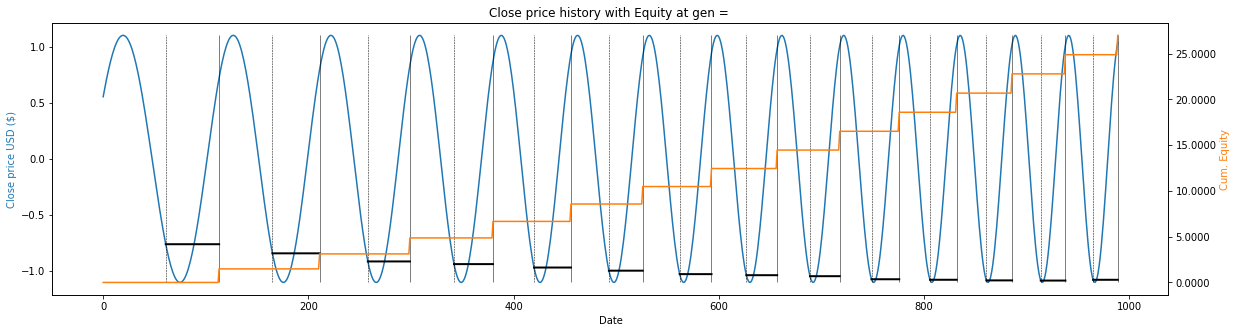

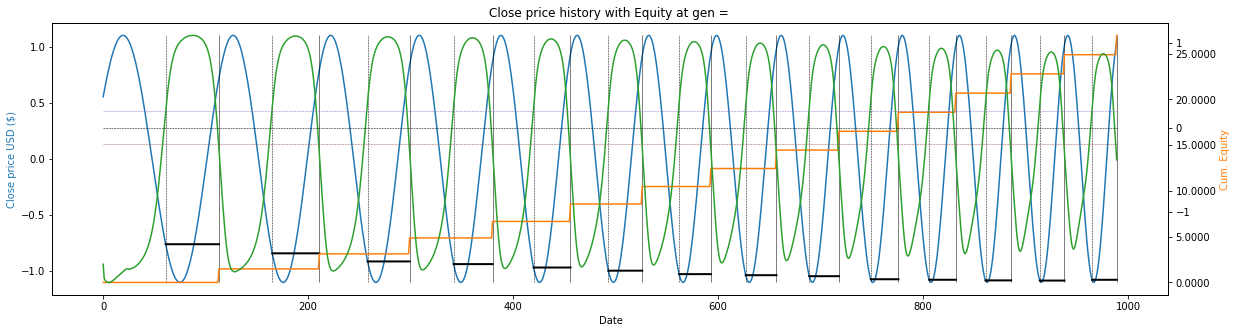

{'buy_count': 14, 'sell_count': 14, 'gain': 26.98436381263388}


{'buy_price': array([-0.7596244 , -0.84083131, -0.91299084, -0.93674811, -0.96718339,
        -0.995177  , -1.02597381, -1.03545914, -1.04427437, -1.07153102,
        -1.07615358, -1.08169875, -1.08327598, -1.07631329]),
 'sell_price': array([0.72221367, 0.79695967, 0.83263257, 0.86792312, 0.9314234 ,
        0.91612336, 0.94283982, 0.98113256, 1.00737587, 1.0070272 ,
        1.01505494, 1.02048335, 1.01358673, 1.03635257]),
 'buy_index': array([ 61, 165, 258, 342, 420, 493, 562, 627, 689, 749, 806, 861, 914,
        965]),
 'sell_index': array([113, 211, 299, 380, 456, 526, 593, 657, 718, 776, 832, 886, 938,
        989]),
 'trade_length': array([52, 46, 41, 38, 36, 33, 31, 30, 29, 27, 26, 25, 24, 24])}

In [19]:
TRADE_COST = 0.001
THRESHOLD = -0.0
TH = 0.2

trader = Trader(threshold=THRESHOLD,
                data_reader=data_reader,
                trade_cost=TRADE_COST,
                th=TH)


pred = nn.create_prediction()

result = trader.calculator_np(pred)

plot_trade_adv(trader, window=trader.window)

plot_trade_adv(trader, trader_signal=pred, window=trader.window)

print(result)
trader.result



In [20]:
# ggggg

In [21]:

TRADE_COST = 0.001
THRESHOLD  = -0.0
TH = 0.2

# Töröljük a korábbi képket

_ = os.system('rm *.png 2> /dev/null')

# Hova tegyüka a thresholdot?

data_reader.x_train[:,0].mean()

# ------------------------------------------------------------------------------    # <-- Test The Program

from sys import maxsize
import time

trader = Trader(threshold=THRESHOLD,
                data_reader=data_reader,
                trade_cost=TRADE_COST,
                th=TH,
                debug=False)

# vvvvvvvvvvvvvvvvvv

internal_ploting = True
repeatable       = True
re_learn         = False

# vvvvvvvvvvvvvvvvvv


if repeatable == True:         # <-- ha azt akarom, hogy mindíg ugyan azt az eredményt kapjam
    np.random.seed(2)

randomer = Randomer(1)         # <-- create a Randomer to controll the mutation




generation = 2000              # <----------- genetration (200)
population = 20                # <----------- population  (20)
factor = 100                   # <----------- randomization factor (25) (10)
factor_intercept = 20          # <----------- randomization factor for intercepts_ (1000)
variable_factor  = True
factor_min = 2                 # <----------- if variable_fac then
factor_max = 50                # <------------if variable_vac then
keep_best = True               # <----------- keep_best (False)
print_generation = (False, 1)  # <----------- hiba kereséshez

select_ratio_weight = 1        # <-- 1 = minden súlyt beválaszt a mutációba 0 = egyiket sem
select_ratio_bias = 1          # <-- 1 = mindent biast beválaszt a mutációba 0 = egyiket sem
variable_select_ratio = False
select_ratio_min = 0.2
select_ratio_max = 0.8


print('--------- init_nn() ----------')
print('mlp.coefs_[0][0]\n', mlp.coefs_[0][0])
print('mlp.intercepts_[0]', mlp.intercepts_[0])

# ----------------------------------- Azt hiszem az egészre már csináltam egy új osztályt de most ezt leteszteljük

start_time = time.time()

coefs = deepcopy(mlp.coefs_)
intercepts = deepcopy(mlp.intercepts_)

backup_mlp = deepcopy(mlp)
working_mlp = deepcopy(mlp)

# ------------------------------------ Dirty hack - ha tovább akarom tanítani akkor

if re_learn == True:
    coefs = deepcopy(best_generation_solution.coefs_)
    intercepts = deepcopy(best_generation_solution.intercepts_)
    backup_mlp = deepcopy(best_generation_solution)
    working_mlp = deepcopy(best_generation_solution)

# ------------------------------------

best_generation_score = -maxsize
best_generation_solution = None

generation_holder = []
population_holder = []
best_indiv_holder = []
best_score_holder = []

have_found = 0

generation_run_time = []
_rt_ss  = []
_prt_ss = []
_tt_ss  = []

for i in range(generation):  # <-- generation part
    
    # Randomize the factor
    if variable_factor:
        factor_weight = (np.random.uniform(low=factor_min, high=factor_max))
        factor_intercept = (np.random.uniform(low=factor_min, high=factor_max))
    
    # Randomize the selection ratio
    if variable_select_ratio:
        select_ratio_weight = (np.random.uniform(low=select_ratio_min, high=select_ratio_max))
        select_ratio_bias = (np.random.uniform(low=select_ratio_min, high=select_ratio_max))
    
    # Mutatja az idő múlását
    if (i % 100 == 0):
        print(i)
    
    best_individual_solution = None
    best_individual_score = best_generation_score

    population_holder = []
    best_indiv_holder = []

    _rt_s  = []
    _prt_s = []
    _tt_s  = []

    g_rt_s = time.time()
    for j in range(population):  # <-- population part
        _r = t()
        if (keep_best == True):
            if (j == 0):
                a = coefs
                b = intercepts
                # pass
            else:
                a = randomer.randomize(coefs,
                                       factor=factor_weight,
                                       select_ratio=select_ratio_weight)
                b = randomer.randomize_intercepts(intercepts,
                                                  factor=factor_intercept,
                                                  select_ratio=select_ratio_bias)
        else:
            a = randomer.randomize(coefs,
                                   factor=factor_weight,
                                   select_ratio=select_ratio_weight)
            b = randomer.randomize_intercepts(intercepts,
                                              factor=factor_intercept,
                                              select_ratio=select_ratio_bias)
        # --> vége a súlymutációnak

        working_mlp.coefs_ = a  # <-- assigne randomized coefs to the working_model
        working_mlp.intercepts_ = b  # <-- assigne randomized intc to the working_model

        _rt_s.append((t() - _r))

        
        # számolja ki a becslést
        _p = t()
        pred = working_mlp.predict(data_reader.x_train)
        _prt_s.append((t() - _p))
        
        
        # mérje vissza a hibát, számolja ki a keresekedéseket
        _t = t()
        # loop vagy np
        # result = trader.calculator_ff(pred)      # <-- for loop (slow) (legacy)
        result = trader.calculator_np(pred)        # <-- numpy (fast)
        _tt_s.append((t() - _t))

        if result['buy_count'] != 0:
            score = result[
                'gain']                     # <-- csak akkor kapja meg az értéket ha volt vétel            
        else:
            score = -maxsize                # <-- egyébkként -maxsize (-9223372036854775807)

        # mindíg tartsa észbe, hogy ki volt a legjobb -> ezt tárolja le
        if (score > best_individual_score
            ):                              # mivel maximalizálni akarunk ezért 'score > best_score'
            best_individual_score = score
            best_individual_solution = deepcopy(working_mlp)
            print('new best_solution find individual = ', j)
            print('i =', i, 'j =', j, '\tscore = ', score)

        # az éppen aktuális egyed score értékét tegyük el
        population_holder.append(score)

    _tt_sum = sum(_tt_s)
    _tt_ss.append(_tt_sum)

    _rt_sum = sum(_rt_s)
    _rt_ss.append(_rt_sum)

    _prt_sum = sum(_prt_s)
    _prt_ss.append(_prt_sum)

    g_rt_e = time.time()
    g_rt = g_rt_e - g_rt_s
    generation_run_time.append(g_rt)

    # generációnként tároljuk le a legjobb egyed score érétkét
    best_score_holder.append(best_individual_score)

    # nyomonkövetés céljából tegyük le egy adott generáció összes egyedének scorját is
    generation_holder.append(population_holder)

    if (print_generation[0]):
        if (i % print_generation[1] == 0):
            print('best_score in generation i = ', i, ' = ',
                  best_individual_score)

    # ha a generáció legjobbja jobb mint a korábbi generáció legjobbja akkor csapja felül
    if (best_individual_score > best_generation_score):
        best_generation_score = best_individual_score
        best_generation_solution = deepcopy(best_individual_solution)
        found_better_in_generation = True
        # A generáció legjobbját tegyük le a coef változóba -> ezáltal a következő generációban ő lesz az ami alapján elindul a mutáció
        coefs = deepcopy(best_generation_solution.coefs_)
        intercepts = deepcopy(best_generation_solution.intercepts_)

        print('best_score in generation i = ', i, ' = ', best_individual_score)
        
        
        # ------------------------------------------------------------------->
        # Az Eq animációhoz

        if internal_ploting:
            # --------------------------------------------------------------->
            # Az Eq animációhoz

            replayed_pred = best_generation_solution.predict(data_reader.x_train)
            _ = trader.calculator_np(replayed_pred) # szükséges, felülcsaja a traderben a dolgokat

            have_found += 1
            plot_trade_adv(trader, save = True, j = have_found, g=i, window=trader.window)
            
    # Save periodicaly
    if (i % 500 == 0):
        joblib.dump(best_generation_solution, 'model.joblib')       # <-- elmenjük
        # clf = joblib.load('model.joblib')                         # <-- betöltjük


    # A kötések hosszának eloszlásat akarom időnként látni
    if (i % 500 == 0):
        trd_time = trader.result['sell_index'] - trader.result['buy_index']
        trd_time = trd_time.astype('int')
        _ = np.unique(trd_time, return_counts=True)
        print(_)

# A globalisan legjobb megoldás alapján csináljuk meg a becslést
test_pred = best_generation_solution.predict(
    data_reader.x_train)  # <-- kiértékeléshez és vizualizációhoz

# A backup_mlp alapján kiszámolhatom, hogy imlyen volt a becslés eredetileg
test_pred_initial = backup_mlp.predict(
    data_reader.x_train
)  # > ha később össze akarom vetni valamelyik mutációval

# Ezek kellenek a plottoláshoz
# generation_holder, best_score_holder, best_generation_solution


# Végül minden esetben updateljük a trader.reult-ot azáltal, hogy meghívjuk a következőt
replayed_pred = best_generation_solution.predict(data_reader.x_train)
replayed_result = trader.calculator_np(replayed_pred)

print('\n', replayed_result)

# Mérjük meg, hogy mennyi ideig fut
running_time = time.time() - start_time
print('\nrunning_time = {:.2f}'.format(running_time))

__init__ Trader
--------- init_nn() ----------
mlp.coefs_[0][0]
 [-0.06059856  0.16090226 -0.36506484 -0.14435588 -0.25797302 -0.2977138
 -0.22912315 -0.1127865  -0.07539038  0.02834773 -0.05901198  0.1352652
 -0.21583756  0.27613793 -0.3451473 ]
mlp.intercepts_[0] [-0.22812157  0.08945836  0.29636135  0.35781267  0.15418204  0.16928308
  0.29890549 -0.07239159 -0.18268323 -0.23849288 -0.27790928  0.22829849
 -0.25794638 -0.17213278  0.23302979]
0
new best_solution find individual =  0
i = 0 j = 0 	score =  26.98436381263388
new best_solution find individual =  7
i = 0 j = 7 	score =  28.72207070730298
best_score in generation i =  0  =  28.72207070730298
(array([23, 26, 27, 28, 29, 30, 31, 33, 35, 37, 40, 42, 47, 52]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
new best_solution find individual =  2
i = 1 j = 2 	score =  28.92322262796096
new best_solution find individual =  6
i = 1 j = 6 	score =  29.144389223596754
best_score in generation i =  1  =  29.144389223596754
new b

In [22]:

create_animated_mp4('price*.png', framerate=1, quite=True)


ok


## Calc trade lenght

Megtehetem mert a trader buy_index sell_index alapján

In [23]:
trader.result

{'buy_price': array([ 0.55351714, -1.09843377, -1.09893325, -1.09992113, -1.09999904,
        -1.09994816, -1.09996002, -1.09994277, -1.09838936, -1.09997114,
        -1.09993432, -1.09984286, -1.09857157, -1.09754133, -1.09907053]),
 'sell_price': array([1.09939149, 1.09990673, 1.09999993, 1.09942351, 1.09994816,
        1.09917283, 1.09938788, 1.09830395, 1.09789108, 1.09992113,
        1.09955842, 1.09854521, 1.09961521, 1.09945849, 1.03635257]),
 'buy_index': array([  0,  74, 175, 266, 349, 426, 498, 566, 631, 692, 751, 808, 863,
        916, 967]),
 'sell_index': array([ 20, 127, 222, 308, 388, 462, 532, 598, 661, 722, 780, 835, 889,
        941, 989]),
 'trade_length': array([20, 53, 47, 42, 39, 36, 34, 32, 30, 30, 29, 27, 26, 25, 22])}

In [24]:
# Nos ha már az ember rááldozott egy csomó időt, hogy tanítsa a modelt, akkor talán illene azt elmenteni

# Save As ...

import pickle
import joblib
import json

joblib.dump(best_generation_solution, 'model.joblib')       # <-- elmenjük
clf = joblib.load('model.joblib')                           # <-- betöltjük

print(type(clf))

joblib.dump(trader, 'trader.joblib')
backup_trader = joblib.load('trader.joblib')

print(type(backup_trader))

joblib.dump(generation_holder, 'generation_holder.joblib')
backup_generation_holder = joblib.load('generation_holder.joblib')

print(type(backup_generation_holder))

<class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>
<class '__main__.Trader'>
<class 'list'>


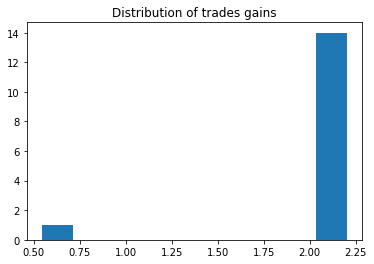

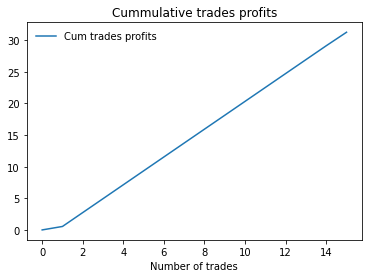

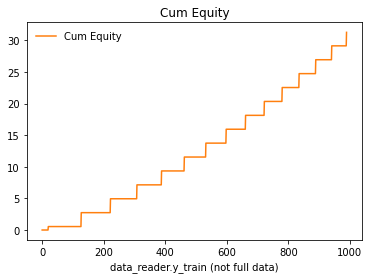

In [25]:

# Nos itt jön az első érdekesség.

# Itt számolom ki ugyanis elöször az egyes tradeken keletkezett nyereséget.
# Ezt ráadáusl úgy teszem, hogy itt már a Trader osztályban eltárol
# sell_price - buy_price alapján számolok

# A trader.result értékét újra lehet számolni ha meghívom
# a trader.calculator_np(replayed_pred)
# a trader.calculator(best_generation_solution.predict(data_reader.x_train))

# Tehát

# Eddig elméletben minden szinkronban van.
# Az adatok majd csak ott csúsznak el amikor a Equity-t egy ábrára teszem
# a tényleges árfolyammal, mert a tényleges árfolyam hosszabb a tanuló
# árfolyamnál méghozzás a visszatekintő ablak hosszávval.

trades_profit = trader.result['sell_price'] - trader.result['buy_price']
# print(trades_profit)

# ------------------------------------------------------------------------------

plt.hist(trades_profit)  # ez az egyik amit majd szeretnék
plt.title('Distribution of trades gains')
plt.show()

# ------------------------------------------------------------------------------

# cum profit (equity)

cum_profit = [0]
for i in range(len(trades_profit)):
    cum_profit.append(cum_profit[i] + trades_profit[i])

# cum_profit = np.cumsum(trade_profit)

plt.plot(cum_profit, label='Cum trades profits')
plt.title('Cummulative trades profits')
plt.xlabel('Number of trades')
plt.legend(frameon=False)
plt.show()

# ------------------------------------------------------------------------------

# cum profit (equity) az idősoron - csak az equity

# eq = np.zeros(data_reader.dataset.shape[0])               # <-- dataset.shape[0] helyett
eq = np.zeros(data_reader.y_train.shape[0])                 # <-- y_train.shape[0]

# Tehát innentől fogva az Equity a data_reader.y_train hosszával lesz azonos hosszú és nem a datasettel.

assert eq.shape[0] == data_reader.y_train.shape[0]
assert eq.shape[0] != data_reader.array.shape[0]

#

# -------------------------------------------------

# Az eq kiszámolása itt történik meg

# erre már nincs is szükség a traderben van

# -------------------------------------------------

for i in range(len(trader.result['sell_price'])):        # <-- lehet a sell_price hossza, de lehet más is
    sell_index = trader.result['sell_index'][i]
    sell_index = int(sell_index)
    eq[sell_index:] = cum_profit[i + 1]
    
# -------------------------------------------------



plt.plot(eq, color='C1', label='Cum Equity')
plt.title('Cum Equity')
plt.xlabel('data_reader.y_train (not full data)')
plt.legend(frameon=False)
plt.show()

# ------------------------------------------------------------------------------

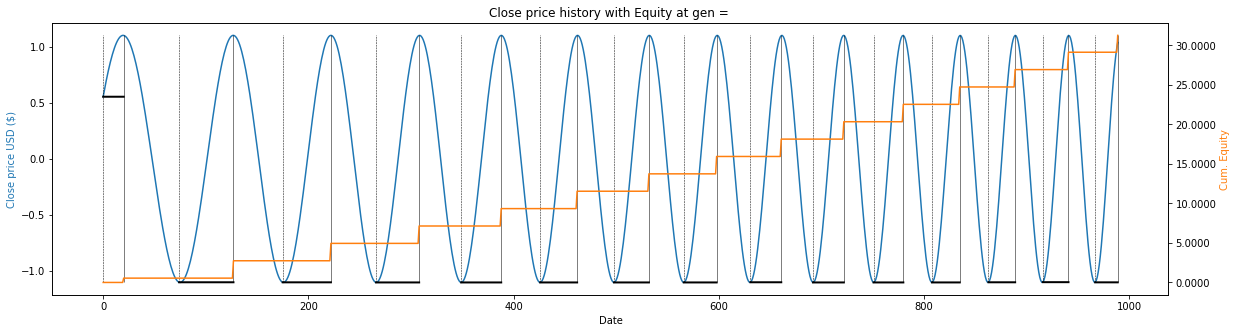

In [26]:

plot_trade_adv(trader, _from=0, _back=0, window=trader.window)


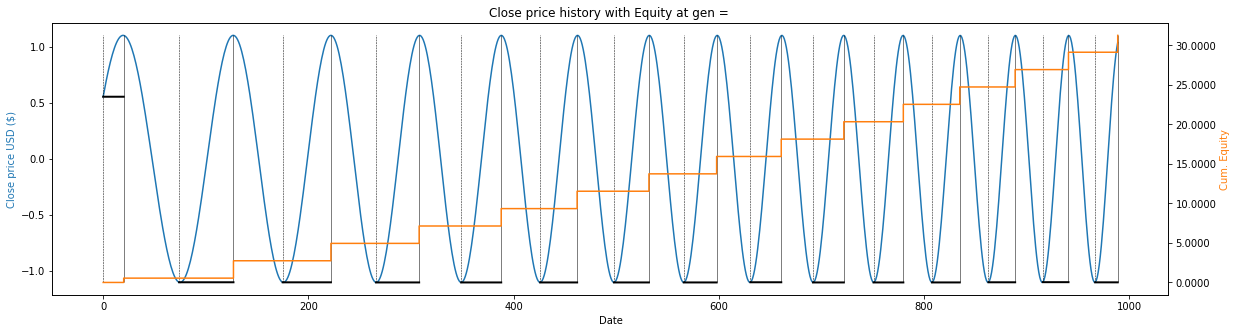

In [27]:

plot_trade_adv(trader, _from=0, _back=0, window=trader.window, step=True)


In [28]:
_from   = IntSlider(min=0, max=1200, step=1, value=0, description='start')
_back   = IntSlider(min=0, max=1200, step=1, value=0, description='back')
_window = IntSlider(min=-10, max=trader.window, step=1, value=trader.window, description='window')
_step   = Checkbox(value=True, description='step')
_trd    = fixed(trader)

ui = ipywidgets.HBox([_from, _back, _window, _step])
params = {'trader': _trd, '_from': _from, '_back': _back, 'window': _window, 'step': _step}
out = ipywidgets.interactive_output(plot_trade_adv, params)
display(ui, out)

Output()

In [29]:
def plot_int(start=0, end=-1, p=True, i=True):

    plt.figure(figsize=(20,5))
    plt.title('Y value history')
    plt.plot(data_reader.y_train[start:end], label = 'y_train')
    if p:
        plt.plot(test_pred[start:end], label = 'test_pred')
    if i:
        plt.plot(test_pred_initial[start:end], label = 'initial')
    plt.xlabel('Time')
    plt.ylabel('Y value')
    plt.hlines(trader.threshold, 0, data_reader.y_train.size-(start-end), lw = 1, linestyles='dashed')
    plt.legend(frameon=False)
    plt.show()

start = IntSlider(min=0, max=1200, step=1, value=0, description='start')
end   = IntSlider(min=-1200, max=-1, step=1, value=1, description='end')

p     = Checkbox(description='predicted', value=True)
i     = Checkbox(description='initial', value=True)

ui = ipywidgets.HBox([start, end, p, i])
out = ipywidgets.interactive_output(plot_int, {'start': start, 'end': end, 'p': p, 'i': i})
display(ui, out)


Output()

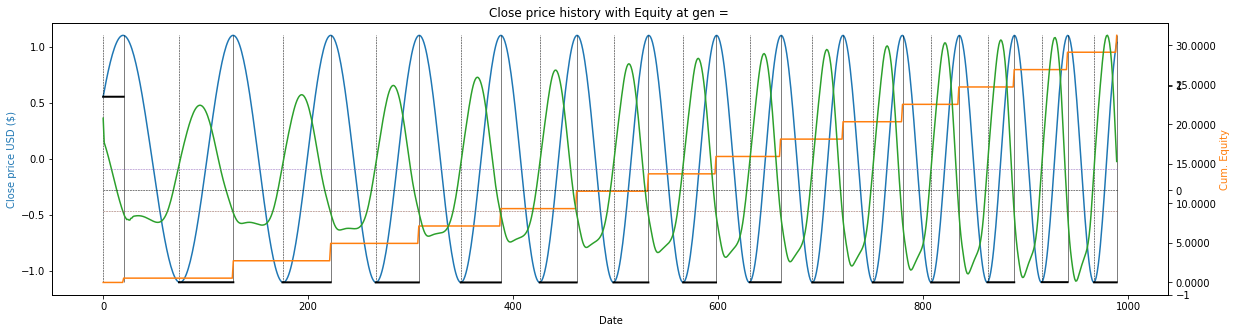

In [30]:
plot_trade_adv(trader, trader_signal=test_pred, window=trader.window, _from=0, _back=0)

## Plotter osztály

In [31]:
# ToDo:

# Be kéne tennem (?) a plotter osztály alá?

import os

os.system('rm MLPPlot.py')
os.system('wget https://raw.githubusercontent.com/JoDeMiro/Micado-Research/main/MLPPlot.py 2> /dev/null')


import importlib
import MLPPlot
importlib.reload(MLPPlot)


def vshow(_net):
    net = _net                                                     # <- a best_solution
    num_input_varialbe = ['X']
    num_input_varialbe = ['X'+str(i) for i in range(30)]
    num_input_varialbe = ['X'+str(i) for i in range(net.coefs_[0].shape[0])] # <- mlp.coefs_[0].shape[0] a bemenetek száma

    # Define the structure of the network
    network_structure = np.hstack(([len(num_input_varialbe)], np.asarray(net.hidden_layer_sizes), [1]))

    print(network_structure)

    # Draw the Neural Network with weights
    network = MLPPlot.DrawNN(network_structure, net.coefs_, num_input_varialbe)
    network.draw(line_width=1)

## Visualise net - Best Solution

[30 15  5  1]


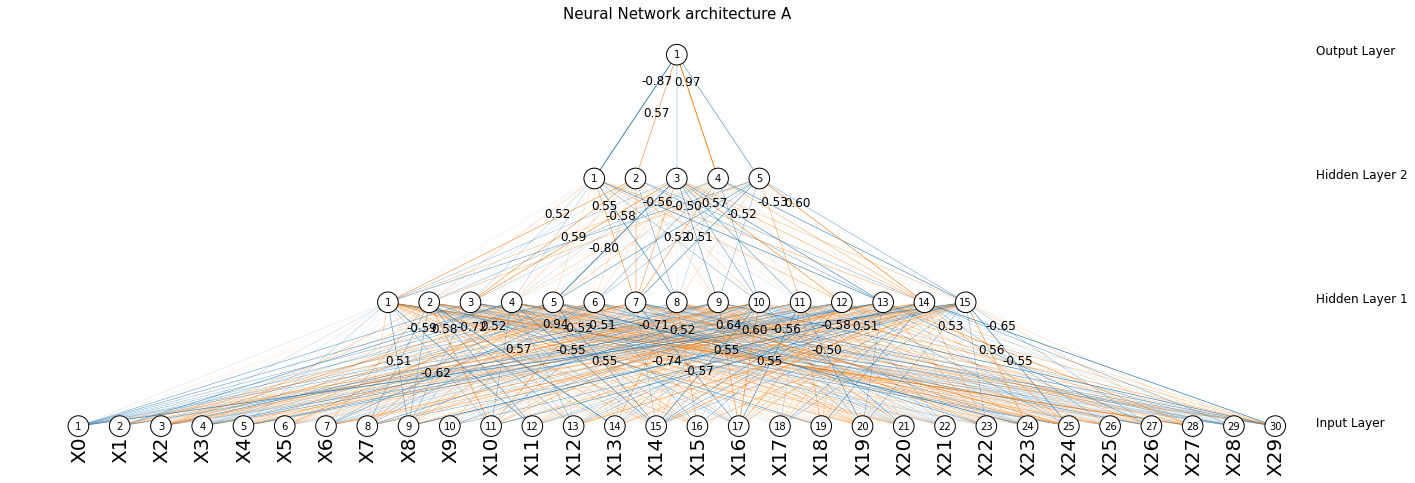

In [32]:
vshow(best_generation_solution)

## Visualise net - Initial ('Empty') Solution

[30 15  5  1]


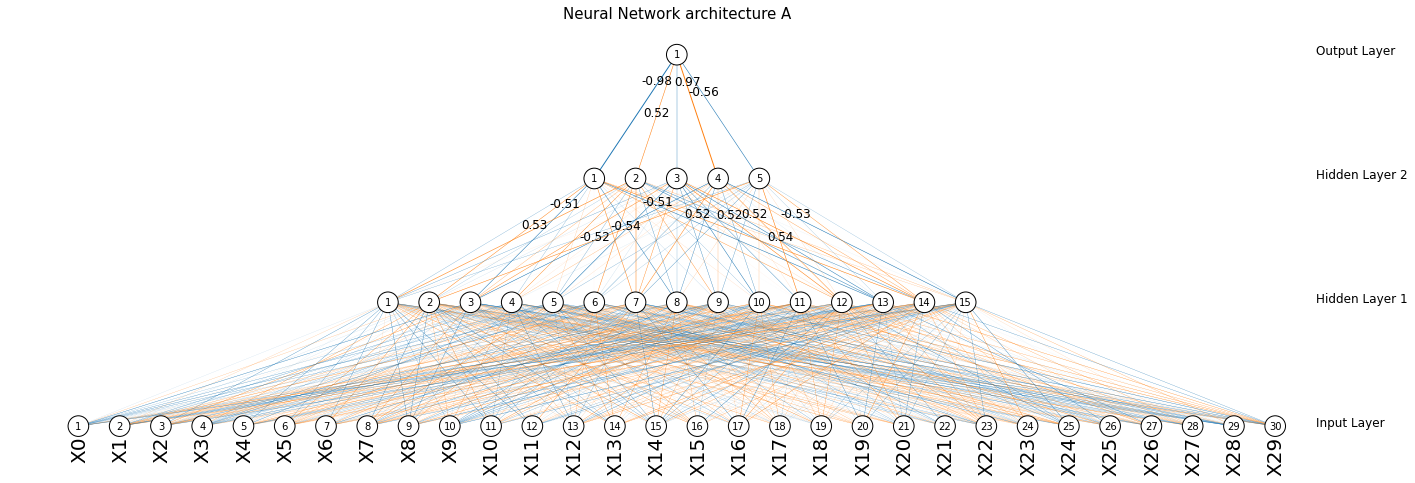

In [33]:
vshow(backup_mlp)


```
# JoDeMiro
```


In [34]:
# ------------------------------------------------------------------------------    # <-- Plotter Class


class Plotter():

    def __init__(self):
        pass

    def plot_generation_scatter(self, generation_holder):

        m = np.zeros((len(generation_holder), len(generation_holder[0])))
        # print(m.shape)

        for i in range(len(generation_holder)):
            for j in range(len(generation_holder[i])):
                m[i, j] = generation_holder[i][j]

        # --- kell csinálni egy [0, 1, 2, ..., 0, 1, 2, ..., 0, 1, 2] vektort is az lesz majd az x -tengely
        n = np.arange(1, len(generation_holder) + 1, 1)
        a = []
        for _ in range(len(generation_holder[0])):
            a.append(n)
        b = np.array(a)
        c = b.flatten()

        # --- ki kell teríteni a mátrixba rakott score-okat és kész is
        s = m.flatten(order='C')
        s = m.flatten(order='F')

        # --- kiszűrni a végelenűl nagyokat (amelyknél nem volt értlemezhető scorre)      # <-- new in v.014

        f = np.zeros(
            s.shape)  # <-- nincs jobb ötletem, minthogy 0-ra cserélem őket
        f[s > -maxsize + 1] = s[s > -maxsize + 1]

        # --- plot
        # plt.scatter(c, s)

        return c, s, f


# ------------------------------------------------------------------------------

    def plot_results(self, _max=None, _show_mid=False):
        if (_show_mid == True):
            fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(18, 5))
        else:
            fig, (a0, a2) = plt.subplots(1, 2, figsize=(12, 5))

        _number_of_generation = len(best_score_holder)
        if (_max == None):
            _number_of_generation = _number_of_generation
        elif (_max > _number_of_generation):
            _number_of_generation = _number_of_generation
        elif (_max < _number_of_generation):
            _number_of_generation = _max

        _x_axis = np.arange(1, _number_of_generation + 1, 1)
        a0.scatter(_x_axis, best_score_holder[:_number_of_generation])
        a0.set_ylabel('Means Square Error')
        a0.set_xlabel('Generation')

        c, s, f = self.plot_generation_scatter(
            generation_holder[:_number_of_generation])

        if (_show_mid == True):
            #a1.plot(generation_holder[:_number_of_generation])
            a1.plot(f[:_number_of_generation])

            a1.set_xlabel('Generation')

        # a2.scatter(c, s)    # <-- nem szűrt adatok
        a2.scatter(c, f)  # <-- szűrt adatok

        a2.set_xlabel('Generation')
        plt.show()

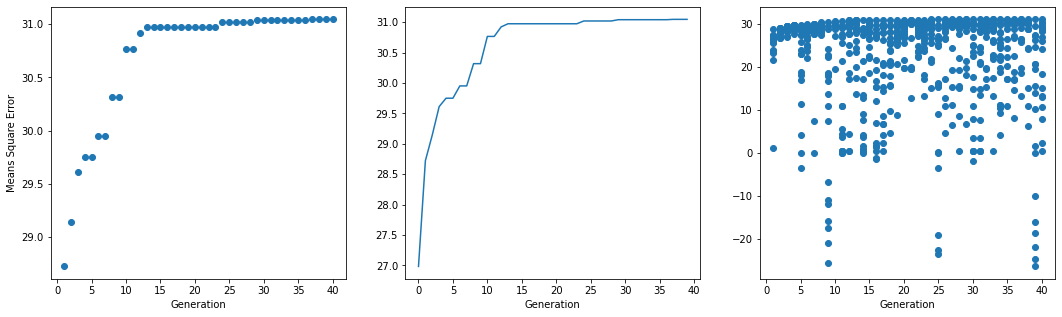

In [35]:
plotter = Plotter()

plotter.plot_results(40, True)

In [36]:
_max = IntSlider(min=40, max=800, step=1, value=120)

interact(plotter.plot_results, _max=_max, _show_mid=True, _show_avg=True);

interactive(children=(IntSlider(value=120, description='_max', max=800, min=40), Checkbox(value=True, descript…


```
# JoDeMiro
```
